# Logistic regression

It is used to calculate or predict the probability of a binary (yes/no) event occurring. An example of logistic regression could be applying machine learning to determine if a tumor  benign or malignant .

## Problem Statement
Assume we have a data set of 14 points each point is pair of (X1, X2) and each point has label, either 0 or 1  
The goal is to estimate a decision boundary which fits our data in the best way.

In [123]:
# Imports
import math, copy
import numpy as np
import matplotlib.pyplot as plt

## Dataset
Assume we have a data set of 14 points each point is pair of (X1, X2) and each point has label, either 0 or 1 

One way to fit the data better is to create more features from each data point. 

We will map the features into all polynomial terms up to the sixth power.

Each pair of (X1,X2) will be transformed to 27 features

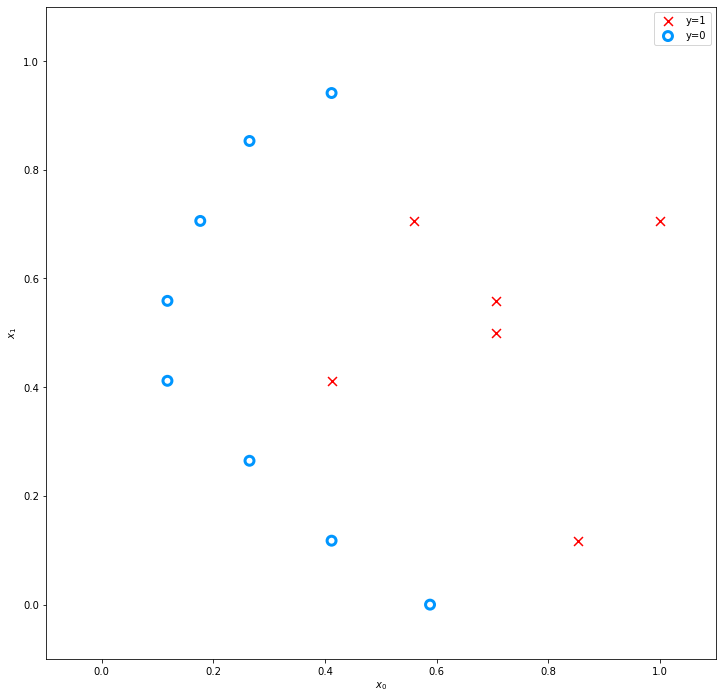

In [124]:
# Define dataset
X = np.array([[1.5, 3.3], [0.7, 2.5], [0.5, 2], [1, 3], [0.5, 1.5], [1,1], [1.5, 0.5],
                [3, 0.5], [2.5, 2], [2, 2.5], [2.1, 0.1],[1.5, 1.5],[2.5, 1.8],[3.5, 2.5]])
# nomalize the dataset netween [0,1]
X_train = (X - np.min(X)) / (np.max(X) - np.min(X))
# define Y labels
y_train = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1])

# Plot the data
fig,ax = plt.subplots(1,1,figsize=(12,12))
""" plots logistic data with two axis """
# Find Indices of Positive and Negative Examples
pos = y_train == 1
neg = y_train == 0
pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
neg = neg.reshape(-1,)

# Plot examples
ax.scatter(X_train[pos, 0], X_train[pos, 1], marker='x', s=80, c = 'red', label="y=1")
ax.scatter(X_train[neg, 0], X_train[neg, 1], marker='o', s=80, label="y=0", facecolors='none', edgecolors='#0096ff', lw=3)

ax.legend(loc='best')

ax.figure.canvas.toolbar_visible = False
ax.figure.canvas.header_visible = False
ax.figure.canvas.footer_visible = False
ax.axis([-0.1, 1.1, -0.1, 1.1])
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_0$')
plt.show()

In [125]:
def map_feature(X, Degree):
    """
    Feature mapping function to polynomial features    
    """
    X1 = np.atleast_1d(X[:, 0])
    X2 = np.atleast_1d(X[:, 1])
    degree = 6
    out = []
    for i in range(1, degree+1):
        for j in range(i + 1):
            out.append((X1**(i-j) * (X2**j)))
    return np.stack(out, axis=1)
# We will map the features into all polynomial terms up to the sixth power.
# Each pair of (X1,X2) will be transformed to 27 features 
X_train =  map_feature(X_train,6)
print("X_train shape: ", X_train.shape)


X_train shape:  (14, 27)


## Model Function
for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

In [126]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

## Cost Function
for regularized logistic regression, the cost function is of the form
$$J(\mathbf{w},b) = \frac{1}{m}  \sum_{i=0}^{m-1} \left[ -y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \right] + \frac{\lambda}{2m}  \sum_{j=0}^{n-1} w_j^2$$

Note that the $b$ parameter is not regularized.

In [127]:
def compute_cost(X, y, w, b, lambda_= 1):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value 
      w : (array_like Shape (n,)) Values of parameters of the model      
      b : scalar Values of bias parameter of the model
      lambda_ : (scalar, float)    Controls amount of regularization
    """

    m, n = X.shape
    z = np.dot(w, np.transpose(X))+b
    w_square_sum = np.sum(w**2)
    f_w_b = sigmoid(z)
    cost_without_reg = np.sum(np.dot(-y,np.log(f_w_b))-np.dot((1-y),np.log((1-f_w_b))))/m
    # Add the regularization cost to get the total cost
    total_cost = cost_without_reg + ((lambda_/(2 * m)) * w_square_sum)
    return total_cost
    

## Optimizer: Gradient decent
We will use Gradient Descent, with  regularization term to added the gradient of W parameters.

The gradient of the regularized cost function has two components as follows:

$$\frac{\partial J(\mathbf{w},b)}{\partial b} = \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})$$

$$\frac{\partial J(\mathbf{w},b)}{\partial w_j} = \left( \frac{1}{m}  \sum_{i=0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) x_j^{(i)} \right) + \frac{\lambda}{m} w_j  \quad\,$$




In [128]:
def compute_gradient(X, y, w, b, lambda_=None): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X : (ndarray Shape (m,n)) variable such as house size 
      y : (array_like Shape (m,1)) actual value 
      w : (array_like Shape (n,1)) values of parameters of the model      
      b : (scalar)                 value of parameter of the model 
      lambda_ : (scalar,float)    regularization constant
    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w. 
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b. 
    """
    m, n = X.shape
    z = np.dot(w, np.transpose(X))+b
    f_w_b = sigmoid(z)
    dj_dw = np.dot((f_w_b-y),X)/m
    dj_db = np.sum(f_w_b-y)/m
    dj_dw = dj_dw + ((lambda_*w)/m)
    return dj_db, dj_dw

def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters, lambda_): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent
      lambda_ (scalar, float)         regularization constant
      
    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """
    
    # number of training examples
    m = len(X)
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in, lambda_)   

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw               
        b_in = b_in - alpha * dj_db              
       
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            cost =  cost_function(X, y, w_in, b_in, lambda_)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")
        
    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

## Fit the model

In [129]:
# Initialize fitting parameters
np.random.seed(1)
initial_w = np.random.rand(X_train.shape[1])-0.5
initial_b = 1.

# Set regularization parameter lambda_ to 1 (you can try varying this)
lambda_ = 0.01;                                          
# Some gradient descent settings
iterations = 50000
alpha = 0.01

w,b, J_history,_ = gradient_descent(X_train, y_train, initial_w, initial_b, 
                                    compute_cost, compute_gradient, 
                                    alpha, iterations, lambda_)

Iteration    0: Cost     0.89   
Iteration 5000: Cost     0.31   
Iteration 10000: Cost     0.24   
Iteration 15000: Cost     0.21   
Iteration 20000: Cost     0.20   
Iteration 25000: Cost     0.19   
Iteration 30000: Cost     0.18   
Iteration 35000: Cost     0.17   
Iteration 40000: Cost     0.17   
Iteration 45000: Cost     0.17   
Iteration 49999: Cost     0.16   


## Plot the model

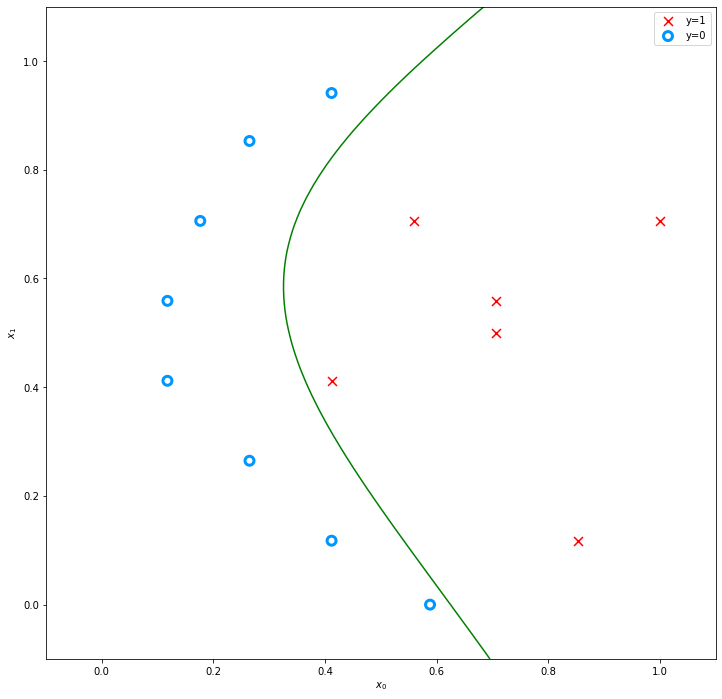

In [130]:
def plot_decision_boundary(w, b):
    # Credit to dibgerge on Github for this plotting code
    u = np.linspace(-0.1, 1.1, 100)
    v = np.linspace(-0.1, 1.1, 100)

    z = np.zeros((len(u), len(v)))
    # Evaluate z = theta*x over the grid
    for i in range(len(u)):
        for j in range(len(v)):
            z[i,j] = sigmoid(np.dot(map_feature(np.array([[u[i], v[j]]]), 6), w) + b)
    
    # important to transpose z before calling contour       
    z = z.T
    plt.contour(u,v,z, [0.3], colors="g")

# Plot the data
fig,ax = plt.subplots(1,1,figsize=(12,12))
""" plots logistic data with two axis """
# Find Indices of Positive and Negative Examples
pos = y_train == 1
neg = y_train == 0
pos = pos.reshape(-1,)  #work with 1D or 1D y vectors
neg = neg.reshape(-1,)

# Plot examples
ax.scatter(X_train[pos, 0], X_train[pos, 1], marker='x', s=80, c = 'red', label="y=1")
ax.scatter(X_train[neg, 0], X_train[neg, 1], marker='o', s=80, label="y=0", facecolors='none', edgecolors='#0096ff', lw=3)

ax.legend(loc='best')

ax.figure.canvas.toolbar_visible = False
ax.figure.canvas.header_visible = False
ax.figure.canvas.footer_visible = False
ax.axis([-0.1, 1.1, -0.1, 1.1])
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_0$')

plot_decision_boundary(w, b)
plt.show()

